<a href="https://colab.research.google.com/github/atifkhawaja01/speech-preprocessing-pipeline/blob/main/audio_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Preprocessing Pipeline – LibriSpeech

This notebook implements a complete voice preprocessing workflow for speech data.
The pipeline includes resampling, normalization, silence trimming, filtering,
feature extraction, and visualization for ML/DL models.


In [ ]:
!pip install torch torchvision torchaudio torchcodec librosa matplotlib numpy


In [ ]:
import os
import torch
import torchaudio
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
os.makedirs("./data", exist_ok=True)

dataset = torchaudio.datasets.LIBRISPEECH(
    root="./data",
    url="test-clean",
    download=True
)

waveform1, sr1, _, _, _, _ = dataset[0]
waveform2, sr2, _, _, _, _ = dataset[1]

print("Sample rates:", sr1, sr2)


Sample rates: 16000 16000


In [ ]:
target_sr = 16000

if sr1 != target_sr:
    resampler1 = torchaudio.transforms.Resample(sr1, target_sr)
    w1 = resampler1(waveform1)
else:
    w1 = waveform1

if sr2 != target_sr:
    resampler2 = torchaudio.transforms.Resample(sr2, target_sr)
    w2 = resampler2(waveform2)
else:
    w2 = waveform2

print("Resampled shapes:", w1.shape, w2.shape)


Resampled shapes: torch.Size([1, 166960]) torch.Size([1, 52400])


In [ ]:
def normalize(wave):
    return wave / wave.abs().max()

w1_norm = normalize(w1)
w2_norm = normalize(w2)


In [ ]:
def trim_silence(wave):
    wave_np = wave.squeeze().numpy()
    trimmed, _ = librosa.effects.trim(wave_np, top_db=20)
    return torch.tensor(trimmed).unsqueeze(0)

w1_trim = trim_silence(w1_norm)
w2_trim = trim_silence(w2_norm)

print("Trimmed shapes:", w1_trim.shape, w2_trim.shape)


Trimmed shapes: torch.Size([1, 151040]) torch.Size([1, 39424])


In [ ]:
import torchaudio.functional as F

w1_filt = F.lowpass_biquad(
    w1_trim,
    sample_rate=target_sr,
    cutoff_freq=4000
)

w2_filt = F.lowpass_biquad(
    w2_trim,
    sample_rate=target_sr,
    cutoff_freq=4000
)

print("Filtered shapes:", w1_filt.shape, w2_filt.shape)


Filtered shapes: torch.Size([1, 151040]) torch.Size([1, 39424])


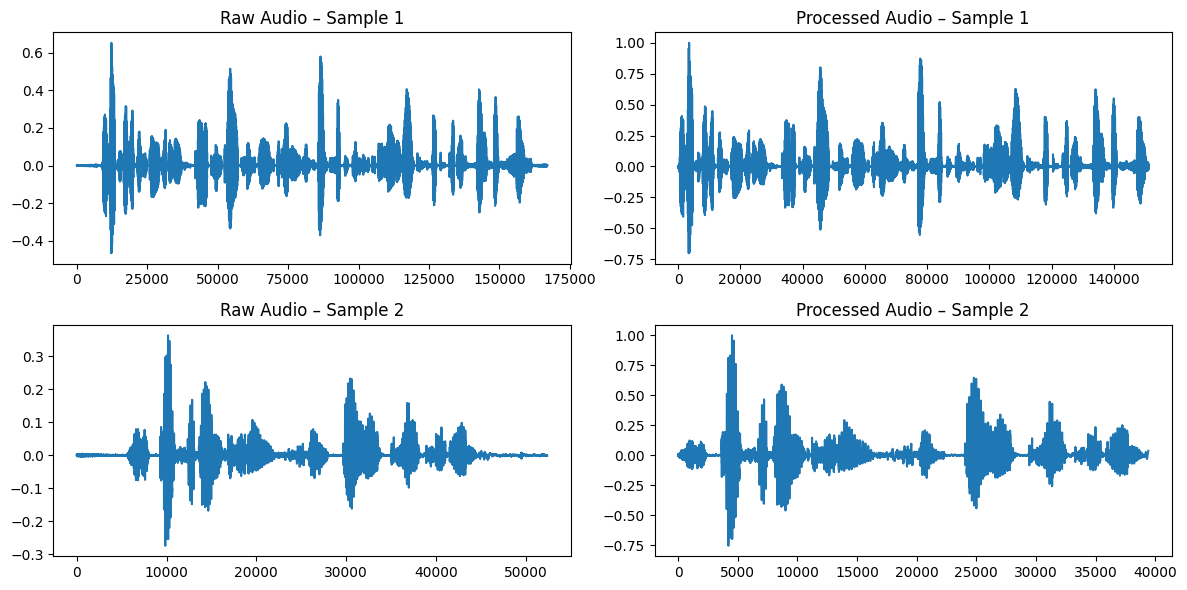

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(w1.squeeze())
plt.title("Raw Audio – Sample 1")

plt.subplot(2, 2, 2)
plt.plot(w1_filt.squeeze())
plt.title("Processed Audio – Sample 1")

plt.subplot(2, 2, 3)
plt.plot(w2.squeeze())
plt.title("Raw Audio – Sample 2")

plt.subplot(2, 2, 4)
plt.plot(w2_filt.squeeze())
plt.title("Processed Audio – Sample 2")

plt.tight_layout()
plt.show()


In [ ]:
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=target_sr,
    n_mels=64
)

mel1 = mel_transform(w1_filt)
mel2 = mel_transform(w2_filt)

mel1_log = torch.log(mel1 + 1e-9)
mel2_log = torch.log(mel2 + 1e-9)

print("Mel shapes:", mel1_log.shape, mel2_log.shape)


Mel shapes: torch.Size([1, 64, 756]) torch.Size([1, 64, 198])


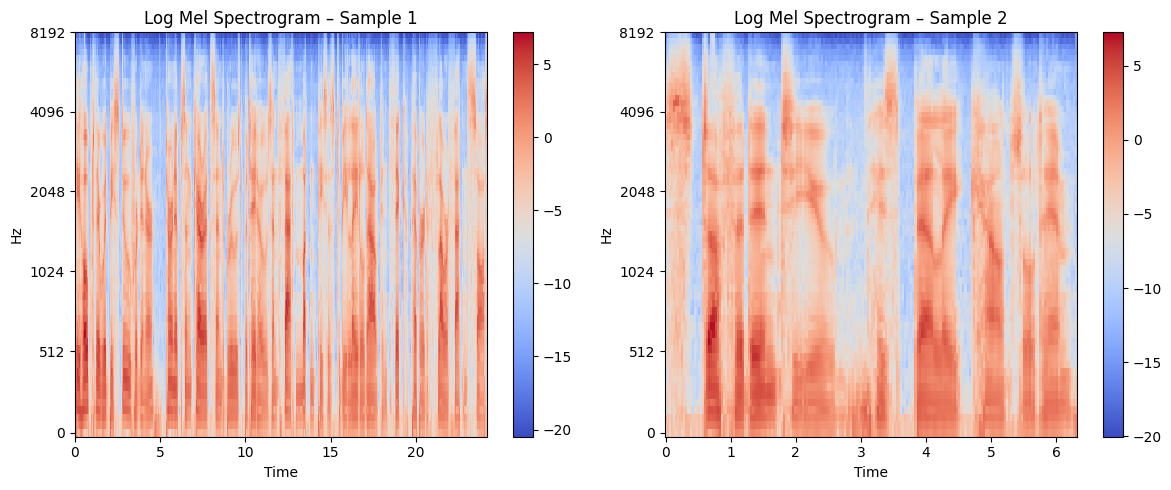

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
librosa.display.specshow(
    mel1_log.squeeze().numpy(),
    sr=target_sr,
    x_axis="time",
    y_axis="mel"
)
plt.title("Log Mel Spectrogram – Sample 1")
plt.colorbar()

plt.subplot(1, 2, 2)
librosa.display.specshow(
    mel2_log.squeeze().numpy(),
    sr=target_sr,
    x_axis="time",
    y_axis="mel"
)
plt.title("Log Mel Spectrogram – Sample 2")
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:
max_time = max(mel1_log.shape[-1], mel2_log.shape[-1])

def pad_mel(mel, max_time):
    pad_amount = max_time - mel.shape[-1]
    if pad_amount > 0:
        return torch.nn.functional.pad(mel, (0, pad_amount))
    else:
        return mel

mel1_padded = pad_mel(mel1_log, max_time)
mel2_padded = pad_mel(mel2_log, max_time)

features_tensor = torch.stack([mel1_padded, mel2_padded])

print("Padded Mel Shapes:", mel1_padded.shape, mel2_padded.shape)
print("Final Features Tensor Shape:", features_tensor.shape)


Padded Mel Shapes: torch.Size([1, 64, 756]) torch.Size([1, 64, 756])
Final Features Tensor Shape: torch.Size([2, 1, 64, 756])


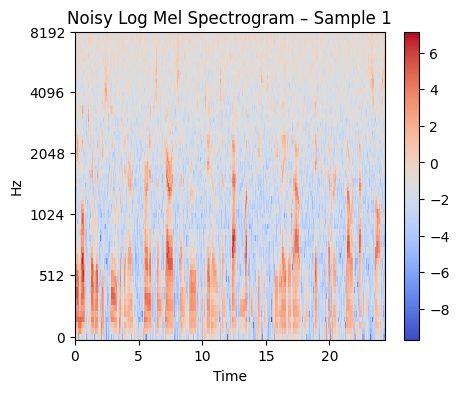

In [ ]:
def add_noise(wave, noise_level=0.02):
    noise = noise_level * torch.randn_like(wave)
    return wave + noise

w1_noisy = add_noise(w1_norm)
w1_noisy_trim = trim_silence(w1_noisy)
mel_noisy = mel_transform(w1_noisy_trim)
mel_noisy_log = torch.log(mel_noisy + 1e-9)

plt.figure(figsize=(5, 4))
librosa.display.specshow(
    mel_noisy_log.squeeze().numpy(),
    sr=target_sr,
    x_axis="time",
    y_axis="mel"
)
plt.title("Noisy Log Mel Spectrogram – Sample 1")
plt.colorbar()
plt.show()
